Import library

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.init as init
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torchvision
import torchvision.transforms as transforms

Download training dataset

In [4]:
# transform = transforms.Compose([transforms.Resize(28),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#                                 transforms.Grayscale(num_output_channels=1),])

# train_set = datasets.CIFAR10(root='./datasets', train=True, download=True, transform=transform)
# test_set = datasets.CIFAR10(root='./datasets', train=False, download=True, transform=transform)

# train_loader = DataLoader(train_set, shuffle=True, batch_size=64, pin_memory=True)
# test_loader = DataLoader(test_set, shuffle=False, batch_size=64, pin_memory=True)
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.Resize(28), transforms.ToTensor(), transforms.Normalize((0,), (1.0/255.0,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=10, shuffle=True, pin_memory=True, drop_last=True, persistent_workers=True)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=10, shuffle=False, pin_memory=True, drop_last=True, persistent_workers=True)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.27MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.12MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.88MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Define MoE Dense

In [5]:
class DenseMoE(nn.Module):
    def __init__(self, num_experts=4, expert_size=256, output_size=10):
        super(DenseMoE, self).__init__()
        self.num_experts = num_experts
        self.flatten = nn.Flatten()

        # Gate network to choose experts
        self.gate = nn.Sequential(
            nn.Linear(28*28, num_experts),
            nn.Softmax(dim=-1)
        )

        # Expert networks
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(28*28, expert_size),
                nn.GELU(),
                nn.Linear(expert_size, expert_size),
                nn.GELU(),
                nn.Linear(expert_size, 10)
            ) for _ in range(num_experts)
        ])

    def forward(self, x):
        # Flatten input
        x = self.flatten(x)

        # Get expert weights from gate
        expert_weights = self.gate(x)

        # Get output from each expert
        expert_outputs = torch.stack([expert(x) for expert in self.experts])

        # Combine expert outputs weighted by gate outputs
        output = torch.sum(expert_outputs*expert_weights.t().unsqueeze(-1), dim=0)

        return output

moe_model = DenseMoE(num_experts=5, expert_size=256, output_size=10).to(device)

moe_model

DenseMoE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (gate): Sequential(
    (0): Linear(in_features=784, out_features=5, bias=True)
    (1): Softmax(dim=-1)
  )
  (experts): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)

Train

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(moe_model.parameters())
max_epoch = 50

# list to store metrics for ploting
moe_train_losses = []
moe_train_accuracies = []
moe_test_losses = []
moe_test_accuracies = []

# training loop
for epoch in range(max_epoch):
    moe_model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = moe_model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted==labels).sum().item()

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss/(i+1)
    test_loss, test_accuracy = evaluate(moe_model, test_loader, criterion)

    print(f"MoE Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    moe_train_losses.append(epoch_loss)
    moe_train_accuracies.append(epoch_accuracy)
    moe_test_losses.append(test_loss)
    moe_test_accuracies.append(test_accuracy)


MoE Epoch [1/50], Loss: 2.6508, Accuracy: 68.77%, Test Loss: 0.5462, Test Accuracy: 80.38%
MoE Epoch [2/50], Loss: 0.4669, Accuracy: 83.34%, Test Loss: 0.4621, Test Accuracy: 83.53%
MoE Epoch [3/50], Loss: 0.4097, Accuracy: 85.24%, Test Loss: 0.4469, Test Accuracy: 84.31%
MoE Epoch [4/50], Loss: 0.3745, Accuracy: 86.35%, Test Loss: 0.4174, Test Accuracy: 84.94%
MoE Epoch [5/50], Loss: 0.3477, Accuracy: 87.17%, Test Loss: 0.3999, Test Accuracy: 85.86%
MoE Epoch [6/50], Loss: 0.3259, Accuracy: 88.09%, Test Loss: 0.3858, Test Accuracy: 86.21%
MoE Epoch [7/50], Loss: 0.3116, Accuracy: 88.44%, Test Loss: 0.3783, Test Accuracy: 86.56%
MoE Epoch [8/50], Loss: 0.2982, Accuracy: 88.90%, Test Loss: 0.3706, Test Accuracy: 86.64%
MoE Epoch [9/50], Loss: 0.2907, Accuracy: 89.21%, Test Loss: 0.3888, Test Accuracy: 86.01%
MoE Epoch [10/50], Loss: 0.2813, Accuracy: 89.54%, Test Loss: 0.3721, Test Accuracy: 86.65%
MoE Epoch [11/50], Loss: 0.2708, Accuracy: 90.00%, Test Loss: 0.3799, Test Accuracy: 86.3

Plot comparision

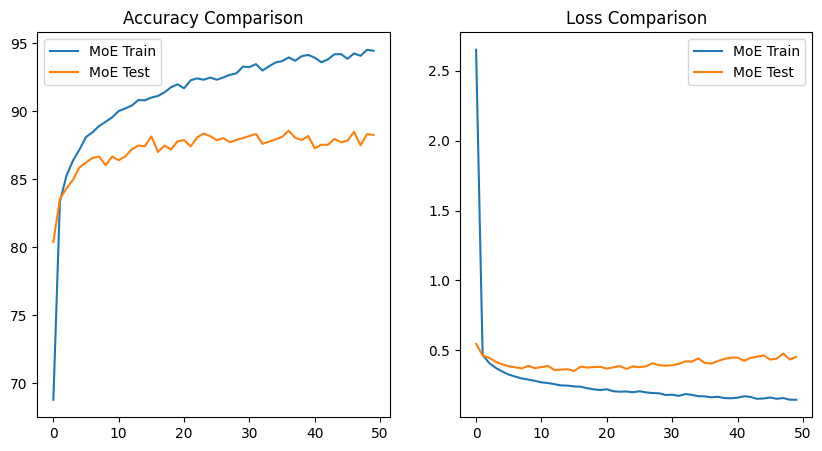

Array values have been successfully written to Dense_MoE_results.txt


In [8]:
# Plot comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(moe_train_accuracies, label='MoE Train')
plt.plot(moe_test_accuracies, label='MoE Test')
plt.title('Accuracy Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(moe_train_losses, label='MoE Train')
plt.plot(moe_test_losses, label='MoE Test')
plt.title('Loss Comparison')
plt.legend()

plt.show()

# Specify the file name
file_name = 'Dense_MoE_results.txt'

# Open the file in write mode
with open(file_name, 'w') as file:
    # Write each value to the file, one per line
    file.write(f"Dense_train_accs {moe_train_accuracies}\n")
    file.write(f"Dense_test_accs {moe_test_accuracies}\n")
    file.write(f"Dense_train_loss {moe_train_losses}\n")
    file.write(f"Dense_test_loss {moe_test_losses}\n")

print(f"Array values have been successfully written to {file_name}")